In [1]:
import warnings
warnings.filterwarnings("ignore")
# !pip install ftfy
import ftfy
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
from math import exp
from numpy import sign
import sys
print(sys.executable)
from PIL import Image # getting images in notebook
# !pip install gensim
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# !pip install tensorflow

# !pip install tensorflow_hub

# !pip install bert-for-tf2
# !pip install sentencepiece

C:\Users\SHWETANK VERMA\Anaconda3\latest\python.exe


[nltk_data] Downloading package stopwords to C:\Users\SHWETANK
[nltk_data]     VERMA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\SHWETANK
[nltk_data]     VERMA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# !pip install tensorflow

# !pip install tensorflow_hub

# !pip install bert-for-tf2
# !pip install sentencepiece

In [3]:
# from tensorflow import keras 
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
#from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
import re
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

In [4]:
train=pd.read_csv(r'C:\Users\SHWETANK VERMA\Documents\Mlstuff\Major-1\Datasets\train.csv')

In [5]:
train.sample(3)

PID                                          Text_data  \
5806  train_pid_5807  People only searches me when they need help : ...   
2554  train_pid_2555  Latuda and Klonopin : I was just recently diag...   
1689  train_pid_1690  I am nobody. : I feel like I am nobody, my lif...   

         Label  
5806  moderate  
2554  moderate  
1689  moderate

In [6]:
test=pd.read_csv(r'C:\Users\SHWETANK VERMA\Documents\Mlstuff\Major-1\Datasets\dev.csv')

In [7]:
print("Training set has {} rows and {} columns.".format(train.shape[0], train.shape[1]))
print("Test set has {} rows and {} columns.".format(test.shape[0], test.shape[1]))

print()
print(train.columns)
print(test.columns)

Training set has 8891 rows and 3 columns.
Test set has 4496 rows and 3 columns.

Index(['PID', 'Text_data', 'Label'], dtype='object')
Index(['PID', 'Text data', 'Label'], dtype='object')


In [8]:
Sentiment = {'moderate': 1,'not depression': 0,'severe':2}
train.Label = [Sentiment[item] for item in train.Label]
test.Label= [Sentiment[item] for item in test.Label]

In [9]:
train.sample(3)

PID                                          Text_data  Label
3827  train_pid_3828  I (16F) think i‚Äôm going to kill myself. : Ever...      1
2964  train_pid_2965  Can someone talk to me im in deep pain : Im so...      1
8888  train_pid_8889  I don‚Äôt think college is right for me : TW: su...      2

In [10]:
test.sample(3)


PID                                          Text data  Label
1404  dev_pid_1405  Passively suicidal : So I think about death al...      1
3494  dev_pid_3495  I feel that it is too late to fix my life : Ev...      0
1961  dev_pid_1962  Stories from those who have been on medication...      1

In [11]:
print('Count NaN:')
print(train.isnull().sum(), '\n')
print('Percentage NaN:')
print(train.isnull().sum()/ len(train))

Count NaN:
PID          0
Text_data    0
Label        0
dtype: int64 

Percentage NaN:
PID          0.0
Text_data    0.0
Label        0.0
dtype: float64


In [12]:
print('Count NaN:')
print(test.isnull().sum(), '\n')
print('Percentage NaN:')
print(test.isnull().sum()/ len(test))

Count NaN:
PID          0
Text data    0
Label        0
dtype: int64 

Percentage NaN:
PID          0.0
Text data    0.0
Label        0.0
dtype: float64


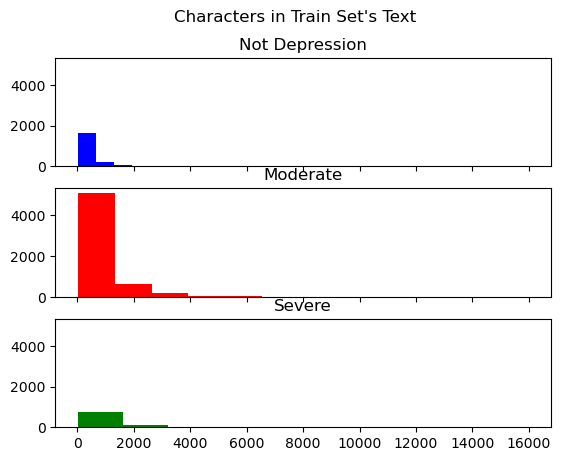

In [13]:
fig, axs = plt.subplots(3, sharex=True, sharey=True)
train_len = train[train['Label'] == 0]['Text_data'].str.len()
axs[0].hist(train_len,color='blue')
axs[0].set_title('Not Depression')
train_len = train[train['Label'] == 1]['Text_data'].str.len()
axs[1].hist(train_len,color='red')
axs[1].set_title('Moderate')
train_len = train[train['Label'] == 2]['Text_data'].str.len()
axs[2].hist(train_len,color='green')
axs[2].set_title('Severe')
fig.suptitle('Characters in Train Set\'s Text')
plt.show()

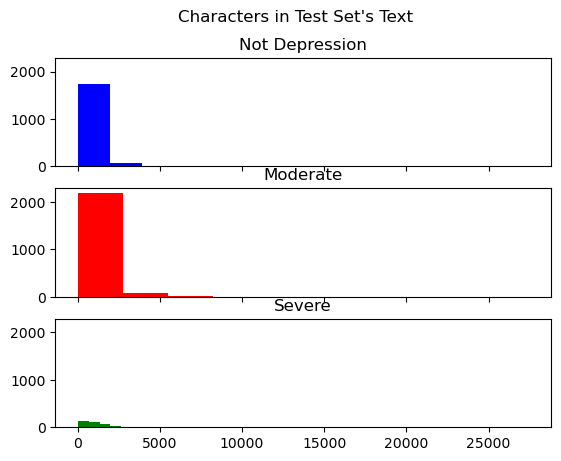

In [14]:
fig, axs = plt.subplots(3, sharex=True, sharey=True)
test_len = test[test['Label'] == 0]['Text data'].str.len()
axs[0].hist(test_len,color='blue')
axs[0].set_title('Not Depression')
test_len = test[test['Label'] == 1]['Text data'].str.len()
axs[1].hist(test_len,color='red')
axs[1].set_title('Moderate')
test_len = test[test['Label'] == 2]['Text data'].str.len()
axs[2].hist(test_len,color='green')
axs[2].set_title('Severe')
fig.suptitle('Characters in Test Set\'s Text')
plt.show()

<Figure size 500x500 with 0 Axes>

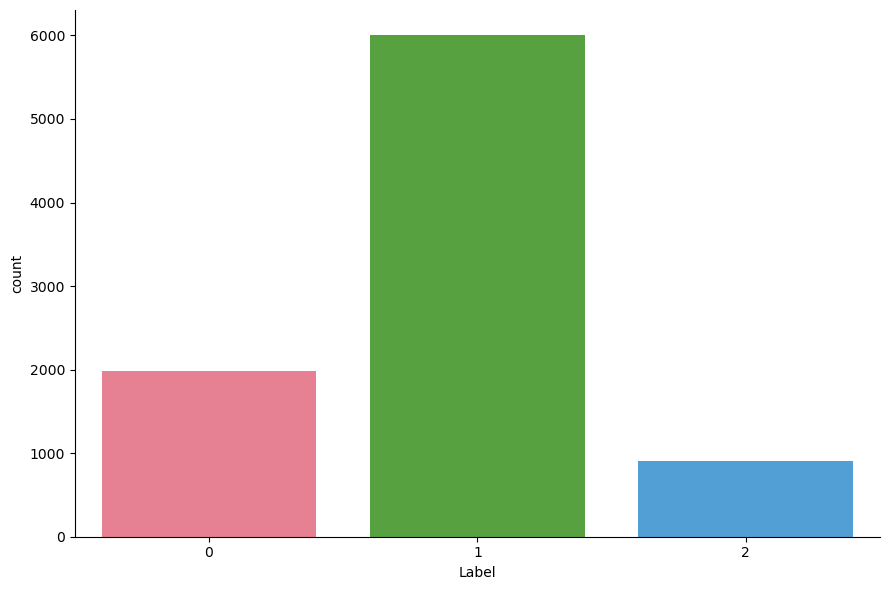

In [15]:
fig = plt.figure(figsize=(5,5))
sns.catplot(x="Label", data=train, kind="count", height=6, aspect=1.5, palette="husl")
plt.show();

In [16]:
import string
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# NLTK Tweet Tokenizer for now
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)

corpus = []

# clean up text
def clean_text(text):
    """
    Copied from other notebooks
    """
    # expand acronyms
    
    # special characters
    text = re.sub(r"\x89√õ_", "", text)
    text = re.sub(r"\x89√õ√í", "", text)
    text = re.sub(r"\x89√õ√ì", "", text)
    text = re.sub(r"\x89√õ√èWhen", "When", text)
    text = re.sub(r"\x89√õ√è", "", text)
    text = re.sub(r"China\x89√õ¬™s", "China's", text)
    text = re.sub(r"let\x89√õ¬™s", "let's", text)
    text = re.sub(r"\x89√õ√∑", "", text)
    text = re.sub(r"\x89√õ¬™", "", text)
    text = re.sub(r"\x89√õ\x9d", "", text)
    text = re.sub(r"√•_", "", text)
    text = re.sub(r"\x89√õ¬¢", "", text)
    text = re.sub(r"\x89√õ¬¢√•√ä", "", text)
    text = re.sub(r"from√•√äwounds", "from wounds", text)
    text = re.sub(r"√•√ä", "", text)
    text = re.sub(r"√•√à", "", text)
    text = re.sub(r"Jap√å_n", "Japan", text)    
    text = re.sub(r"√å¬©", "e", text)
    text = re.sub(r"√•¬®", "", text)
    text = re.sub(r"Suru√å¬§", "Suruc", text)
    text = re.sub(r"√•√á", "", text)
    text = re.sub(r"√•¬£3million", "3 million", text)
    text = re.sub(r"√•√Ä", "", text)
    
    # emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    
    """
    Our Stuff
    """
    # remove numbers
    text = re.sub(r'[0-9]', '', text)
    
    # remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        text = text.replace(p, '')
        
    # remove urls
    text = re.sub(r'http\S+', '', text)
    
    # tokenize
    text = tknzr.tokenize(text)
    
    # remove stopwords
    text = [w.lower() for w in text if not w in stop_words]
    corpus.append(text)
    
    # join back
    text = ' '.join(text)
    
    return text

In [17]:
%%time
train['Text_data'] = train['Text_data'].apply(lambda s: clean_text(s))
test['Text data'] = test['Text data'].apply(lambda s: clean_text(s))

# see some cleaned data
train.sample(10)

Wall time: 12.2 s


PID                                          Text_data  Label
3571  train_pid_3572  thought going end depression lmao disclaimer p...      1
8841  train_pid_8842  i reject diagnosis my doctor diagnosed severe ...      2
3480  train_pid_3481  explain dont get choose deppressed answer foll...      1
4271  train_pid_4272  changed life better still miserable this year ...      1
1504  train_pid_1505  i lost tonight i hate new years didnt i stay h...      1
6863  train_pid_6864         goodbye hopefully pain last decade removed      0
1908  train_pid_1909  im tired oflying im sitting alone downstairs e...      1
802    train_pid_803  worst new years ever so much pomp circumstance...      1
3714  train_pid_3715  alone new years this one goes brothers sad eno...      1
2344  train_pid_2345  feeling powerlesshelpless sorry i need vent my...      1

In [18]:
texts = train['Text_data'].to_numpy()
word_freq = {}

for text in texts:
    for word in text.split():
        word_freq[word] = word_freq.get(word, 0) + 1

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 40

tokenizer = Tokenizer()

tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = len(word_index) + 1
print('Found %s unique tokens.' % (num_words - 1))

# pad 
data = pad_sequences(
    sequences, 
    maxlen=MAX_SEQUENCE_LENGTH,
    padding='post', 
    truncating='post'
)

labels = train['Label'].to_numpy()
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 13266 unique tokens.
Shape of data tensor: (8891, 40)
Shape of label tensor: (8891,)


In [20]:
x_train = data
y_train = labels

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.metrics import roc_auc_score

vectorizer = CountVectorizer()
x_train_vectorized = vectorizer.fit_transform(train['Text_data'])

# print vocabulary
print(vectorizer.get_feature_names()[2500:2600])

['courageous', 'course', 'courses', 'coursework', 'court', 'courtesy', 'cousin', 'cousindads', 'cousins', 'cousy', 'cover', 'coverage', 'covered', 'covering', 'covers', 'covid', 'cow', 'coward', 'cowardice', 'cowards', 'cower', 'cowered', 'coworker', 'coworkers', 'coz', 'cozy', 'cps', 'cptsd', 'crab', 'crack', 'cracked', 'cracking', 'cracks', 'cradle', 'cradled', 'craft', 'crafts', 'craig', 'craigslist', 'cramps', 'crap', 'crappier', 'crappy', 'crash', 'crashes', 'crashing', 'crave', 'craved', 'craving', 'cravings', 'crawl', 'crawled', 'crawling', 'crazed', 'craziest', 'crazy', 'crazyo', 'cream', 'create', 'created', 'creates', 'creating', 'creation', 'creations', 'creative', 'creativity', 'creator', 'creators', 'creature', 'creatures', 'credit', 'creep', 'creeped', 'creeping', 'creeps', 'creepy', 'crept', 'crevice', 'crib', 'crickets', 'cried', 'cries', 'crieswhy', 'crime', 'crimes', 'criminal', 'cringe', 'cringey', 'cringing', 'cringy', 'cripple', 'crippled', 'cripples', 'crippling',

In [22]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [23]:
X_train, X_cv, Y_train, Y_cv = train_test_split(train["Text_data"], train["Label"], test_size = 0.3, random_state=42)

In [24]:
X_train = vectorizer.fit_transform(X_train)
X_train = X_train.toarray()
print(X_train.shape)

(6223, 11938)


In [25]:
X_cv = vectorizer.transform(X_cv)
X_cv = X_cv.toarray()
print(X_cv.shape)

(2668, 11938)


In [26]:
X_test = vectorizer.transform(test["Text data"])
X_test = X_test.toarray()
print(X_test.shape)

(4496, 11938)


In [27]:
vocab = vectorizer.get_feature_names()
print(f"Printing first 100 vocabulary samples:\n{vocab[:100]}")

Printing first 100 vocabulary samples:
['aa', 'aaah', 'aback', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abbandoned', 'abdomen', 'abdominal', 'abide', 'abilify', 'abilities', 'ability', 'abit', 'able', 'ablewant', 'abnormal', 'abomination', 'aborted', 'about', 'aboutalthough', 'above', 'abraham', 'abroad', 'abroadare', 'abruptly', 'abs', 'abscense', 'absence', 'absent', 'absenteeism', 'absentmindedly', 'absolute', 'absolutely', 'absorb', 'absorbing', 'abstinence', 'absurd', 'absurdly', 'abt', 'abundance', 'abuse', 'abused', 'abuser', 'abuses', 'abusing', 'abusive', 'abysmal', 'abyss', 'academic', 'academically', 'academics', 'accelerate', 'accentuation', 'accept', 'acceptance', 'accepted', 'accepting', 'access', 'accessible', 'accident', 'accidentally', 'accidents', 'accompany', 'accomplish', 'accomplished', 'accomplishing', 'accomplishment', 'accomplishments', 'according', 'account', 'accountability', 'accountable', 'accounts', 'accrued', 'accumulated', 'accumulating', 'ac

In [28]:
distribution = np.sum(X_train, axis=0)

print("Printing first 100 vocab-dist pairs:")

for tag, count in zip(vocab[:100], distribution[:100]):
    print(count, tag)

Printing first 100 vocab-dist pairs:
1 aa
6 aaah
6 aback
19 abandon
14 abandoned
6 abandoning
8 abandonment
5 abbandoned
8 abdomen
1 abdominal
1 abide
14 abilify
31 abilities
90 ability
5 abit
473 able
5 ablewant
6 abnormal
7 abomination
3 aborted
35 about
1 aboutalthough
1 above
9 abraham
16 abroad
1 abroadare
1 abruptly
1 abs
1 abscense
7 absence
1 absent
1 absenteeism
8 absentmindedly
72 absolute
184 absolutely
2 absorb
4 absorbing
1 abstinence
3 absurd
1 absurdly
5 abt
1 abundance
73 abuse
37 abused
6 abuser
8 abuses
34 abusing
133 abusive
1 abysmal
8 abyss
13 academic
5 academically
2 academics
1 accelerate
1 accentuation
145 accept
11 acceptance
78 accepted
23 accepting
27 access
2 accessible
45 accident
16 accidentally
1 accidents
1 accompany
40 accomplish
18 accomplished
2 accomplishing
33 accomplishment
8 accomplishments
22 according
18 account
2 accountability
7 accountable
21 accounts
1 accrued
1 accumulated
4 accumulating
7 accusations
6 accuse
5 accused
6 accusing
1 accust

In [29]:
forest = RandomForestClassifier() 
forest = forest.fit( X_train, Y_train)

In [30]:
predictions = forest.predict(X_cv) 
print("Accuracy: ", accuracy_score(Y_cv, predictions))

Accuracy:  0.8789355322338831


In [31]:
print(classification_report(Y_cv, predictions))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78       598
           1       0.86      0.99      0.92      1797
           2       0.96      0.63      0.76       273

    accuracy                           0.88      2668
   macro avg       0.92      0.76      0.82      2668
weighted avg       0.89      0.88      0.87      2668



In [32]:
#using tf-idf

In [33]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report

In [34]:
X_train, X_test , y_train, y_test = train_test_split(train['Text_data'].values,train['Label'].values,test_size=0.2,random_state=123,stratify=train['Label'].values)
tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)

tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

In [35]:
classifier = RandomForestClassifier()

classifier.fit(tfidf_train_vectors,y_train)

RandomForestClassifier()

In [36]:
y_pred = classifier.predict(tfidf_test_vectors)

In [37]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.71      0.80       397
           1       0.87      0.98      0.92      1201
           2       0.97      0.68      0.80       181

    accuracy                           0.89      1779
   macro avg       0.93      0.79      0.84      1779
weighted avg       0.90      0.89      0.88      1779



In [38]:
print("Accuracy: ", accuracy_score(y_test,y_pred))

Accuracy:  0.8898257448004497


In [39]:
# Split data into train and test sets
import gensim
X_train, X_test, y_train, y_test = train_test_split (train['Text_data'], train['Label'] , test_size=0.2)
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

In [40]:
w2v_model.wv.index_to_key

[' ',
 'e',
 'i',
 't',
 'n',
 'a',
 's',
 'o',
 'l',
 'r',
 'd',
 'g',
 'h',
 'y',
 'm',
 'c',
 'p',
 'u',
 'w',
 'f',
 'k',
 'v',
 'b',
 '‚Äô',
 'x',
 'j',
 'z',
 '!',
 'q',
 '‚Äù',
 '‚Äú',
 '–æ',
 '–Ω',
 '—Ç',
 '–∞',
 '–∏',
 '–µ',
 '–¥',
 '—É',
 '—è',
 '—Å',
 '–≤',
 '—Ä',
 '‚Äò',
 '–º',
 '–ø',
 '—å',
 '—á',
 '–∑',
 '–∫',
 '–ª',
 '‚Äî',
 '‚Ä¢',
 '–π',
 '–∂',
 '–≥',
 '—Ö',
 '—ã',
 '¬£',
 '√©',
 '–±',
 '‚Ä¶',
 '—à',
 '¬¥',
 '¬¨',
 '\u200b',
 '¬∞',
 'ü¶ë',
 '—é',
 'ƒô',
 '»ô',
 'ü•∞',
 '¬Ø',
 '¬ª',
 'ü•∫',
 '‚Äû',
 '¬´',
 '‚ÑÖ',
 '¬ø',
 '≈Ç',
 'ƒÖ',
 'ü•¥']

In [41]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

In [42]:

for i, v in enumerate(X_train_vect):
    print(len(X_train.iloc[i]), len(v))

141 141
333 333
84 84
1503 1503
175 175
664 664
127 127
224 224
26 26
418 418
32 32
283 283
772 772
269 269
544 544
909 909
170 170
19 19
23 23
144 144
215 215
165 165
1140 1140
55 55
279 279
110 110
127 127
686 686
395 395
718 718
506 506
225 225
94 94
1267 1267
1227 1227
248 248
634 634
80 80
163 163
438 438
83 83
927 927
90 90
433 433
688 688
189 189
58 58
334 334
1194 1194
2134 2134
724 724
99 99
80 80
71 71
190 190
52 52
1395 1395
781 781
448 448
857 857
386 386
362 362
188 188
131 131
456 456
181 181
146 146
1549 1549
3994 3994
1562 1562
101 101
1149 1149
410 410
879 879
35 35
255 255
332 332
91 91
36 36
94 94
452 452
1767 1767
158 158
561 561
608 608
2255 2255
831 831
43 43
215 215
157 157
1193 1193
155 155
1749 1749
204 204
253 253
721 721
31 31
205 205
107 107
457 457
227 227
517 517
231 231
1539 1539
146 146
35 35
128 128
38 38
274 274
48 48
145 145
183 183
387 387
140 140
158 158
290 290
606 606
214 214
206 206
32 32
1227 1227
258 258
355 355
592 592
47 47
153 153
36 36
308 

In [43]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [44]:
# Are our sentence vector lengths consistent?
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train.iloc[i]), len(v))

141 100
333 100
84 100
1503 100
175 100
664 100
127 100
224 100
26 100
418 100
32 100
283 100
772 100
269 100
544 100
909 100
170 100
19 100
23 100
144 100
215 100
165 100
1140 100
55 100
279 100
110 100
127 100
686 100
395 100
718 100
506 100
225 100
94 100
1267 100
1227 100
248 100
634 100
80 100
163 100
438 100
83 100
927 100
90 100
433 100
688 100
189 100
58 100
334 100
1194 100
2134 100
724 100
99 100
80 100
71 100
190 100
52 100
1395 100
781 100
448 100
857 100
386 100
362 100
188 100
131 100
456 100
181 100
146 100
1549 100
3994 100
1562 100
101 100
1149 100
410 100
879 100
35 100
255 100
332 100
91 100
36 100
94 100
452 100
1767 100
158 100
561 100
608 100
2255 100
831 100
43 100
215 100
157 100
1193 100
155 100
1749 100
204 100
253 100
721 100
31 100
205 100
107 100
457 100
227 100
517 100
231 100
1539 100
146 100
35 100
128 100
38 100
274 100
48 100
145 100
183 100
387 100
140 100
158 100
290 100
606 100
214 100
206 100
32 100
1227 100
258 100
355 100
592 100
47 100
153 100
3

In [45]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [46]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       373
           1       0.90      0.98      0.94      1236
           2       0.99      0.65      0.78       170

    accuracy                           0.90      1779
   macro avg       0.92      0.80      0.85      1779
weighted avg       0.91      0.90      0.90      1779



In [48]:
print("Accuracy: ", accuracy_score(y_test,y_pred))

Accuracy:  0.9038785834738617


In [49]:
# sentence_encoder_layer = hub.KerasLayer(
#     "https://tfhub.dev/google/universal-sentence-encoder/4"
# )

In [50]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# import tensorflow_decision_forests as tfdf
# model = keras.Sequential()
# inputs = layers.Input(shape=(), dtype=tf.string)
# outputs = sentence_encoder_layer(inputs)
# preprocessor = keras.Model(inputs=inputs, outputs=outputs)
# model_1 = tfdf.keras.GradientBoostedTreesModel(preprocessing=preprocessor)

In [51]:
# model_2 = tfdf.keras.GradientBoostedTreesModel()

In [52]:
# # Compiling model_1
# model_1.compile(metrics=["Accuracy", "Recall", "Precision", "AUC"])
# # Here we do not specify epochs as, TF-DF trains exactly one epoch of the dataset
# model_1.fit(train)

# # Compiling model_2
# model_2.compile(metrics=["Accuracy", "Recall", "Precision", "AUC"])
# # Here we do not specify epochs as, TF-DF trains exactly one epoch of the dataset
# model_2.fit(train)

In [53]:
# logs_1 = model_1.make_inspector().training_logs()
# print(logs_1)

In [54]:
# logs_2 = model_2.make_inspector().training_logs()
# print(logs_2)

In [55]:
# print("model_1 summary: ")
# print(model_1.summary())
# print()
# print("model_2 summary: ")
# print(model_2.summary())

In [56]:
# results = model_1.evaluate(test, return_dict=True, verbose=0)
# print("model_1 Evaluation: \n")
# for name, value in results.items():
#     print(f"{name}: {value:.4f}")

# results = model_2.evaluate(test, return_dict=True, verbose=0)
# print("model_2 Evaluation: \n")
# for name, value in results.items():
#     print(f"{name}: {value:.4f}")

In [57]:
# test.reset_index(inplace=True, drop=True)
# for index, row in test.iterrows():
#     text = tf.expand_dims(row["Text data"], axis=0)
#     preds = model_1.predict_step(text)
#     preds = tf.squeeze(tf.round(preds))
#     print(f"Text: {row['Text data']}")
#     print(f"Prediction: {int(preds)}")
#     print(f"Ground Truth : {row['Label']}")
#     if index == 10:
#         break

In [58]:

total_vocabulary =set(word for tweet in train for word in tweet)
len(total_vocabulary)

print('There are {} unique tokens in the dataset.'.format(
    len(total_vocabulary)))

There are 13 unique tokens in the dataset.


In [59]:
# glove = {}

# with open(r'C:\Users\aanan\Documents\Major-1\glove.twitter.27B.100d.txt', 'rb') as f:

#     for line in f:

#         parts = line.split()

#         word = parts[0].decode('utf-8')

#         if word in total_vocabulary: 
#             vector = np.array(parts [1:], dtype=np.float32)
#             glove[word] = vector

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\aanan\\Documents\\Major-1\\glove.twitter.27B.100d.txt'

In [ ]:
# class W2vVectorizer(object):
#     def __init__(self, w2v): 
#         #Takes in a dictionary of words and vectors as input self.dimensions = len(w2v[next (iter(glove))])
#         self.w2v = w2v
#         if len(w2v) == 0:
#             self.dimensions = 0
#         else:
#             self.dimensions = len(w2v[next(iter(glove))])
#         # Note: Even though it doesn't do anything,
#         #it's required that this object implement a fit method 
#         # or else it can't be used in a scikit-learn pipeline

#         def fit(self, X, y):
#             return self

#         def transform(self, X):
#             #X should be a series of lists of tokens
#             return np.array([
#                 np.mean([self.w2v[w] for w in words if w in self.w2v]
#                     or [np.zeros(self.dimensions)], axis=0) for words in X])



In [ ]:
# Instantiate a mean word embedding vectorizer using glove embeddings

vectorizer = W2vVectorizer(glove)

In [ ]:
#Use vectorizer to transform tokenized data to vectors
type(train)
# X_glove = vectorizer.transform(train['Text_data'])

In [65]:
!pip install fasttext

In [67]:
import fasttext.util

In [68]:
ft = fasttext.load_model('cc.en.300.bin')

In [69]:
ft.get_dimension()

300

In [72]:
ft.get_nearest_neighbors('sad')

[(0.7654699683189392, 'saddening'),
 (0.7333880662918091, 'sadder'),
 (0.7270680665969849, 'sad.The'),
 (0.7142772078514099, 'sad.This'),
 (0.7122252583503723, 'sad.I'),
 (0.7057977318763733, 'saddened'),
 (0.7021587491035461, 'sad.It'),
 (0.7002950310707092, 'sad.And'),
 (0.6964119672775269, 'sad.But'),
 (0.6918020248413086, 'Sad')]

In [74]:
embedding_vector_length = 50

In [75]:
max_features = 5000

In [76]:
#Initialize embedding matrix
embedding_matrix_fasttext = np.zeros((max_features + 1, embedding_vector_length))
print(embedding_matrix_fasttext.shape)

(5001, 50)


In [78]:
token=tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
token.fit_on_texts(train.Text_data)

In [79]:
word_index = token.word_index

In [80]:
for word, i in sorted(token.word_index.items(),key=lambda x:x[1]):
    if i > (max_features+1):
        break
    try:
        embedding_vector = ft[word] #Reading word's embedding from Glove model for a given word
        embedding_matrix_fasttext[i] = embedding_vector
    except:
        pass

In [90]:
# A simpleRNN without any pretrained embeddings and one dense layer
from keras.models import Sequential
from tqdm import tqdm
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
model = Sequential()
maxlen = 500
model.add(tf.keras.layers.Embedding(max_features + 1, #Vocablury size
                                    embedding_vector_length, #Embedding size
                                    weights=[embedding_matrix_fasttext], #Embeddings taken from pre-trained model
                                    trainable=False, #As embeddings are already available, we will not train this layer. It will act as lookup layer.
                                    input_length=maxlen) #Number of words in each review
         )
model.add(SimpleRNN(100))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 50)           250050    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               15100     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 265,756
Trainable params: 15,706
Non-trainable params: 250,050
_________________________________________________________________


In [121]:
X_train, X_test, y_train, y_test = train_test_split(train.Text_data.values, train.Label.values,  
                                                  random_state=42, 
                                                  test_size=0.2)

In [122]:
X_train_seq=token.texts_to_sequences(X_train)
X_test_seq=token.texts_to_sequences(X_test)


In [107]:
import tensorflow 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [123]:
X_train_pad = tensorflow.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = tensorflow.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=maxlen)

In [126]:
y_train = y_train[0:1779]
X_train_pad = X_train_pad[0:1779]
y_test = y_test[0:1779]

print(X_train_pad.shape[0]," ",y_train.shape[0]," ",X_test_pad.shape[0]," ",y_test.shape[0])

1779   1779   1779   1779


In [125]:
history = model.fit(X_train_pad,
                    y_train,
                    epochs=3,
                    batch_size=32,          
                    validation_data=(X_test_pad, y_test))

Epoch 1/3


ValueError: in user code:

    File "C:\Users\SHWETANK VERMA\Anaconda3\latest\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\SHWETANK VERMA\Anaconda3\latest\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\SHWETANK VERMA\Anaconda3\latest\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\SHWETANK VERMA\Anaconda3\latest\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\SHWETANK VERMA\Anaconda3\latest\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\SHWETANK VERMA\Anaconda3\latest\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\SHWETANK VERMA\Anaconda3\latest\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\SHWETANK VERMA\Anaconda3\latest\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\SHWETANK VERMA\Anaconda3\latest\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\SHWETANK VERMA\Anaconda3\latest\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 6) vs (None, 1)).
